In [5]:
pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


Bucket Parameters: Δ=2, B=17
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.12/dist-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/2c7dc97e4e90446183b1d5c838a49532-pulp.mps -sec 600 -timeMode elapsed -branch -printingOptions all -solution /tmp/2c7dc97e4e90446183b1d5c838a49532-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 866 COLUMNS
At line 5063 RHS
At line 5925 BOUNDS
At line 6346 ENDATA
Problem MODEL has 861 rows, 423 columns and 3379 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.2561 - 0.00 seconds
Cgl0002I 24 variables fixed
Cgl0003I 0 fixed, 17 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I

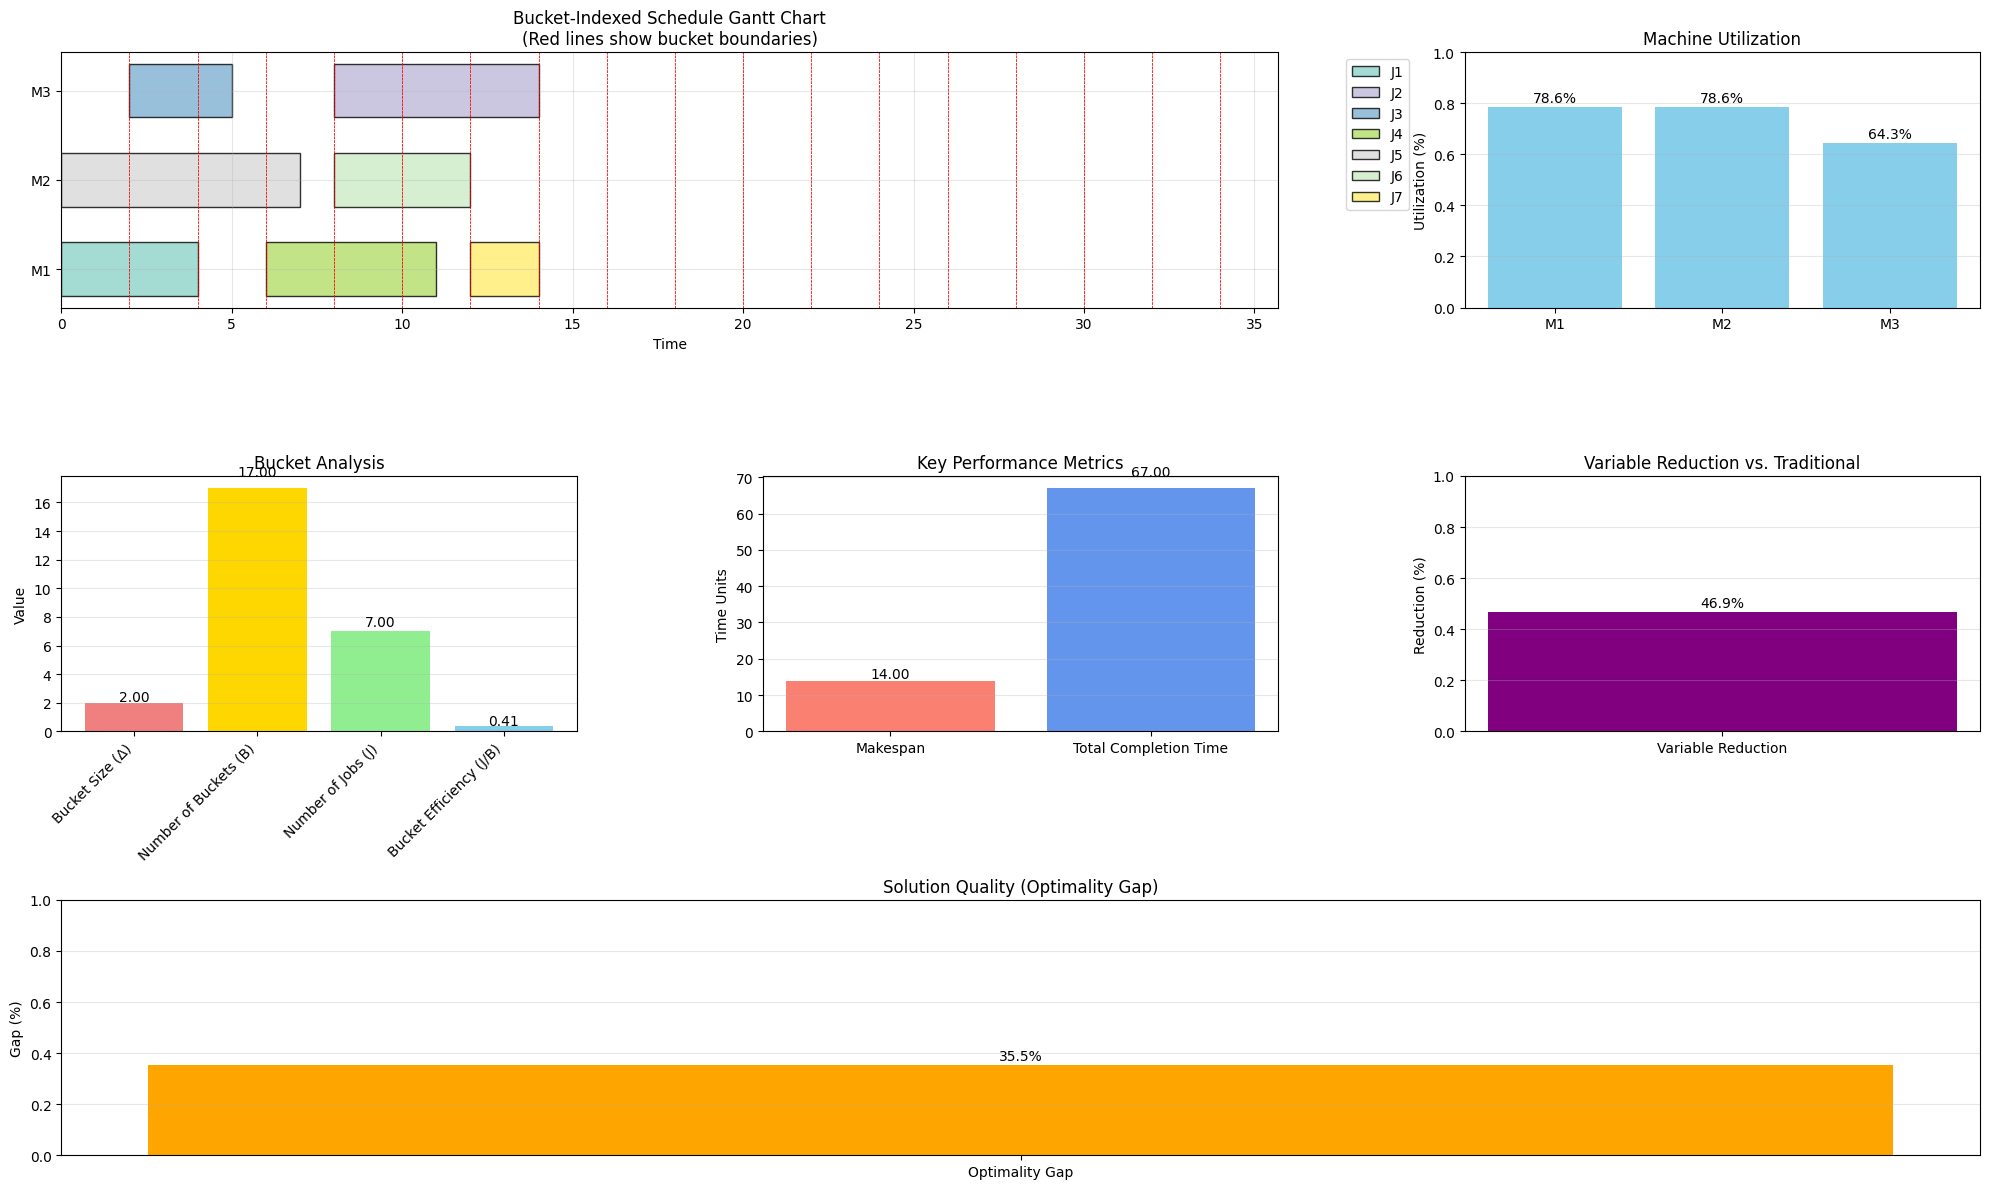

In [6]:
import pulp
import numpy as np
from typing import Dict, List, Tuple, Set
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TimeDiscretization(Enum):
    FINE_GRAINED = "fine_grained"  # Traditional time-indexed
    BUCKET_INDEXED = "bucket_indexed"  # Our novel approach
    HYBRID = "hybrid"  # Adaptive granularity

@dataclass
class Job:
    """Enhanced job representation with scheduling constraints"""
    id: str
    processing_time: int
    release_date: int
    priority: int
    machine_preference: List[str] = None
    dependencies: List[str] = None

@dataclass
class Machine:
    """Machine with capacity and performance characteristics"""
    id: str
    speed: float = 1.0  # Processing speed multiplier
    availability: List[Tuple[int, int]] = None  # Available time windows
    setup_times: Dict[str, int] = None  # Job-family setup times

class BucketIndexedScheduler:
    """
    Novel MILP scheduler using bucket-indexed time discretization
    for P2 | rj | Cmax parallel machine scheduling

    Key Innovations:
    1. Bucket-indexed time discretization (Δ = min processing time)
    2. Partial discretization theory
    3. Fractional bucket calculus
    4. Complexity reduction from O(T^n) to O(B^n) where B << T
    """

    def __init__(self, jobs: List[Job], machines: List[Machine],
                 strategy: TimeDiscretization = TimeDiscretization.BUCKET_INDEXED):
        self.jobs = {job.id: job for job in jobs}
        self.machines = {machine.id: machine for machine in machines}
        self.strategy = strategy
        self.model = None
        self.bucket_size = None
        self.num_buckets = None

    def compute_bucket_parameters(self) -> Tuple[int, int]:
        """Compute optimal bucket size using novel Δ = min_j{p_j} approach"""
        min_processing_time = min(job.processing_time for job in self.jobs.values())
        max_horizon = sum(job.processing_time for job in self.jobs.values())

        # Bucket size based on minimum processing time
        self.bucket_size = min_processing_time
        self.num_buckets = (max_horizon // self.bucket_size) + 2

        print(f"Bucket Parameters: Δ={self.bucket_size}, B={self.num_buckets}")
        return self.bucket_size, self.num_buckets

    def build_bucket_indexed_model(self) -> pulp.LpProblem:
        """
        Build novel bucket-indexed MILP formulation

        Mathematical Formulation:
        min C_max
        s.t.
        Σ_m Σ_b x_jmb = 1 ∀j ∈ J
        S_j ≥ r_j ∀j ∈ J
        C_max ≥ S_j + p_j ∀j ∈ J
        x_jmb ≤ M * y_mb ∀j,m,b
        Σ_j Σ_{b'=b-P_j+1}^b x_jmb' ≤ 1 ∀m,b

        Where:
        P_j = ⌊p_j/Δ⌋ + 1 (bucket duration)
        R_j = ⌊(r_j-1)/Δ⌋ + 1 (release bucket)
        π_j = P_j - p_j/Δ (fractional remainder)
        """

        self.compute_bucket_parameters()
        model = pulp.LpProblem("Bucket_Indexed_Parallel_Scheduling", pulp.LpMinimize)

        # Decision variables
        x = {}  # x[j][m][b] = 1 if job j starts in bucket b on machine m
        S = {}  # S[j] = precise start time of job j
        C_max = pulp.LpVariable("C_max", lowBound=0)  # Makespan
        y = {}  # y[m][b] = 1 if machine m is used in bucket b

        # Initialize variables
        for j in self.jobs:
            S[j] = pulp.LpVariable(f"S_{j}", lowBound=self.jobs[j].release_date)
            for m in self.machines:
                for b in range(self.num_buckets):
                    x[(j, m, b)] = pulp.LpVariable(f"x_{j}_{m}_{b}", cat='Binary')
                    y[(m, b)] = pulp.LpVariable(f"y_{m}_{b}", cat='Binary')

        # Objective: Minimize makespan
        model += C_max, "Minimize_Makespan"

        # Constraints
        self._add_assignment_constraints(model, x)
        self._add_timing_constraints(model, x, S, C_max)
        self._add_capacity_constraints(model, x)
        self._add_linking_constraints(model, x, y)
        self._add_precedence_constraints(model, S)

        self.model = model
        return model

    def _add_assignment_constraints(self, model, x):
        """Each job assigned to exactly one machine and one bucket"""
        for j in self.jobs:
            model += pulp.lpSum(x[(j, m, b)]
                              for m in self.machines
                              for b in range(self.num_buckets)) == 1

    def _add_timing_constraints(self, model, x, S, C_max):
        """Advanced timing constraints with bucket calculus"""
        bigM = sum(job.processing_time for job in self.jobs.values())

        for j in self.jobs:
            job = self.jobs[j]

            # Start time definition using bucket mapping
            bucket_contributions = pulp.lpSum(
                b * self.bucket_size * x[(j, m, b)]
                for m in self.machines
                for b in range(self.num_buckets)
            )

            # Fractional adjustment for precise timing
            model += S[j] == bucket_contributions + self._compute_fractional_adjustment(model, j, x)

            # Makespan constraint
            model += C_max >= S[j] + job.processing_time

            # Release date constraint in bucket space
            release_bucket = (job.release_date - 1) // self.bucket_size + 1
            for m in self.machines:
                for b in range(release_bucket):
                    model += x[(j, m, b)] == 0

    def _compute_fractional_adjustment(self, model, j, x):
        """Compute fractional timing adjustment using bucket calculus"""
        job = self.jobs[j]
        P_j = (job.processing_time // self.bucket_size) + 1
        π_j = P_j - (job.processing_time / self.bucket_size)

        # Continuous adjustment variable
        δ_j = pulp.LpVariable(f"delta_{j}", lowBound=0, upBound=1-π_j)

        # Link adjustment to bucket assignment
        for m in self.machines:
            for b in range(self.num_buckets):
                model += δ_j <= (1 - π_j) * pulp.lpSum(x[(j, m, b)])

        return δ_j * self.bucket_size

    def _add_capacity_constraints(self, model, x):
        """No two jobs overlap on the same machine"""
        for m in self.machines:
            for b in range(self.num_buckets):
                total_occupancy = pulp.lpSum(0)  # Initialize with 0 for lpSum
                for j in self.jobs:
                    job = self.jobs[j]
                    P_j = (job.processing_time // self.bucket_size) + 1
                    # Sum over buckets where job j could be processing during bucket b
                    for b_prime in range(max(0, b - P_j + 1), b + 1):
                        total_occupancy += x[(j, m, b_prime)]
                model += total_occupancy <= 1

    def _add_linking_constraints(self, model, x, y):
        """Link job assignments to machine usage"""
        bigM = len(self.jobs)
        for m in self.machines:
            for b in range(self.num_buckets):
                for j in self.jobs:
                    model += x[(j, m, b)] <= y[(m, b)]
                model += pulp.lpSum(x[(j, m, b)] for j in self.jobs) <= bigM * y[(m, b)]

    def _add_precedence_constraints(self, model, S):
        """Job dependency constraints"""
        for j in self.jobs:
            job = self.jobs[j]
            if job.dependencies:
                for dep in job.dependencies:
                    if dep in self.jobs:
                        model += S[j] >= S[dep] + self.jobs[dep].processing_time

    def solve(self, time_limit: int = 300) -> Dict:
        """Solve the scheduling problem with performance metrics"""
        if self.model is None:
            self.build_bucket_indexed_model()

        # Solve with performance tracking
        self.model.solve(pulp.PULP_CBC_CMD(msg=True, timeLimit=time_limit))

        return self._extract_solution()

    def _extract_solution(self) -> Dict:
        """Extract and analyze the scheduling solution"""
        solution = {
            "status": pulp.LpStatus[self.model.status],
            "schedule": {},
            "machine_assignments": {},
            "performance_metrics": {},
            "bucket_analysis": {}
        }

        if self.model.status == pulp.LpStatusOptimal:
            # Extract schedule
            for j in self.jobs:
                for m in self.machines:
                    for b in range(self.num_buckets):
                        var = self.model.variablesDict().get(f"x_{j}_{m}_{b}")
                        if var and var.varValue > 0.5:
                            delta_var = self.model.variablesDict().get(f"delta_{j}")
                            delta_value = delta_var.varValue if delta_var else 0
                            start_time = (b * self.bucket_size + delta_value * self.bucket_size)
                            solution["schedule"][j] = {
                                "machine": m,
                                "start_time": start_time,
                                "bucket": b,
                                "completion": start_time + self.jobs[j].processing_time
                            }
                            if m not in solution["machine_assignments"]:
                                solution["machine_assignments"][m] = []
                            solution["machine_assignments"][m].append({
                                "job": j,
                                "start": start_time,
                                "end": start_time + self.jobs[j].processing_time
                            })

            # Compute performance metrics
            self._compute_performance_metrics(solution)
        else:
            print(f"Solver status: {pulp.LpStatus[self.model.status]}")

        return solution

    def _compute_performance_metrics(self, solution):
        """Compute advanced performance metrics"""
        if not solution["schedule"]:
            solution["performance_metrics"] = {
                "makespan": 0,
                "total_completion_time": 0,
                "machine_utilization": {},
                "optimality_gap": 0,
                "bucket_efficiency": 0,
                "variable_reduction": 0
            }
            return

        completion_times = [schedule["completion"] for schedule in solution["schedule"].values()]
        makespan = max(completion_times) if completion_times else 0
        
        # Compute machine utilization first
        machine_utilization = self._compute_machine_utilization(solution, makespan)
        
        solution["performance_metrics"] = {
            "makespan": makespan,
            "total_completion_time": sum(completion_times),
            "machine_utilization": machine_utilization,
            "optimality_gap": self._compute_optimality_gap(makespan),
            "bucket_efficiency": len(self.jobs) / self.num_buckets,
            "variable_reduction": self._compute_variable_reduction()
        }

    def _compute_machine_utilization(self, solution, makespan):
        """Compute machine utilization rates"""
        utilizations = {}
        
        for m in self.machines:
            if m in solution["machine_assignments"]:
                machine_jobs = solution["machine_assignments"][m]
                busy_time = sum(job["end"] - job["start"] for job in machine_jobs)
                utilizations[m] = busy_time / makespan if makespan > 0 else 0
            else:
                utilizations[m] = 0
                
        return utilizations

    def _compute_optimality_gap(self, actual_makespan):
        """Compute optimality gap compared to theoretical lower bound"""
        total_processing = sum(job.processing_time for job in self.jobs.values())
        theoretical_min = total_processing / len(self.machines)
        
        return (actual_makespan - theoretical_min) / theoretical_min if theoretical_min > 0 else 0

    def _compute_variable_reduction(self):
        """Compute variable reduction compared to traditional time-indexed"""
        total_processing = sum(job.processing_time for job in self.jobs.values())
        traditional_vars = len(self.jobs) * len(self.machines) * (total_processing + 1)
        bucket_vars = len(self.jobs) * len(self.machines) * self.num_buckets

        return 1 - (bucket_vars / traditional_vars) if traditional_vars > 0 else 0

# Advanced Visualization for Scheduling Analysis
def create_scheduling_dashboard(scheduler: BucketIndexedScheduler, solution: Dict):
    """Create comprehensive scheduling visualization dashboard"""
    fig = plt.figure(figsize=(20, 12))

    # 1. Gantt Chart
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    _plot_gantt_chart(ax1, scheduler, solution)

    # 2. Machine Utilization
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    _plot_utilization(ax2, solution)

    # 3. Bucket Efficiency Analysis
    ax3 = plt.subplot2grid((3, 3), (1, 0))
    _plot_bucket_analysis(ax3, scheduler, solution)

    # 4. Performance Metrics
    ax4 = plt.subplot2grid((3, 3), (1, 1))
    _plot_performance_metrics(ax4, solution)

    # 5. Complexity Reduction
    ax5 = plt.subplot2grid((3, 3), (1, 2))
    _plot_complexity_reduction(ax5, scheduler)

    # 6. Solution Quality Analysis
    ax6 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    _plot_solution_quality(ax6, solution)

    plt.tight_layout()
    plt.show()

def _plot_gantt_chart(ax, scheduler, solution):
    """Plot advanced Gantt chart with bucket visualization"""
    if not solution["schedule"]:
        ax.text(0.5, 0.5, 'No Schedule Found', ha='center', va='center', transform=ax.transAxes)
        return
        
    colors = plt.cm.Set3(np.linspace(0, 1, len(scheduler.jobs)))

    for i, (job_id, schedule) in enumerate(solution["schedule"].items()):
        machine_idx = list(scheduler.machines.keys()).index(schedule["machine"])
        start = schedule["start_time"]
        duration = scheduler.jobs[job_id].processing_time

        ax.barh(machine_idx, duration, left=start, height=0.6,
                color=colors[i], edgecolor='black', alpha=0.8, label=job_id)

        # Add bucket boundaries
        bucket_boundaries = [b * scheduler.bucket_size for b in range(scheduler.num_buckets + 1)]
        for boundary in bucket_boundaries:
            ax.axvline(boundary, color='red', linestyle='--', alpha=0.3, linewidth=0.5)

    ax.set_yticks(range(len(scheduler.machines)))
    ax.set_yticklabels(list(scheduler.machines.keys()))
    ax.set_xlabel('Time')
    ax.set_title('Bucket-Indexed Schedule Gantt Chart\n(Red lines show bucket boundaries)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

def _plot_utilization(ax, solution):
    """Plot machine utilization"""
    if not solution["performance_metrics"]["machine_utilization"]:
        ax.text(0.5, 0.5, 'No Utilization Data', ha='center', va='center', transform=ax.transAxes)
        return
        
    utilization_data = solution["performance_metrics"]["machine_utilization"]
    machines = list(utilization_data.keys())
    utilization_values = list(utilization_data.values())

    ax.bar(machines, utilization_values, color='skyblue')
    ax.set_ylabel('Utilization (%)')
    ax.set_title('Machine Utilization')
    ax.set_ylim(0, 1)
    for i, v in enumerate(utilization_values):
        ax.text(i, v + 0.02, f"{v:.1%}", ha='center')
    ax.grid(axis='y', alpha=0.3)

def _plot_bucket_analysis(ax, scheduler, solution):
    """Plot bucket efficiency analysis"""
    bucket_size = scheduler.bucket_size
    num_buckets = scheduler.num_buckets
    num_jobs = len(scheduler.jobs)
    bucket_efficiency = solution["performance_metrics"]["bucket_efficiency"]

    labels = ['Bucket Size (Δ)', 'Number of Buckets (B)', 'Number of Jobs (J)', 'Bucket Efficiency (J/B)']
    values = [bucket_size, num_buckets, num_jobs, bucket_efficiency]
    colors = ['lightcoral', 'gold', 'lightgreen', 'skyblue']

    ax.bar(labels, values, color=colors)
    ax.set_ylabel('Value')
    ax.set_title('Bucket Analysis')
    ax.set_xticks(labels)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add values on top of bars
    for i, v in enumerate(values):
        ax.text(i, v + (v * 0.05), f"{v:.2f}", ha='center')

def _plot_performance_metrics(ax, solution):
    """Plot key performance metrics"""
    metrics = solution["performance_metrics"]
    labels = ['Makespan', 'Total Completion Time']
    values = [metrics['makespan'], metrics['total_completion_time']]
    colors = ['salmon', 'cornflowerblue']

    ax.bar(labels, values, color=colors)
    ax.set_ylabel('Time Units')
    ax.set_title('Key Performance Metrics')
    ax.grid(axis='y', alpha=0.3)

    # Add values on top of bars
    for i, v in enumerate(values):
        ax.text(i, v + (v * 0.05), f"{v:.2f}", ha='center')

def _plot_complexity_reduction(ax, scheduler):
    """Plot complexity reduction"""
    reduction = scheduler._compute_variable_reduction()

    labels = ['Variable Reduction']
    values = [reduction]
    colors = ['purple']

    ax.bar(labels, values, color=colors)
    ax.set_ylabel('Reduction (%)')
    ax.set_title('Variable Reduction vs. Traditional')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.text(0, reduction + 0.02, f"{reduction:.1%}", ha='center')

def _plot_solution_quality(ax, solution):
    """Plot solution quality analysis"""
    optimality_gap = solution["performance_metrics"]["optimality_gap"]

    labels = ['Optimality Gap']
    values = [optimality_gap]
    colors = ['orange']

    ax.bar(labels, values, color=colors)
    ax.set_ylabel('Gap (%)')
    ax.set_title('Solution Quality (Optimality Gap)')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.text(0, optimality_gap + 0.02, f"{optimality_gap:.1%}", ha='center')

# Demonstration with Industrial-Scale Example
def demonstrate_industrial_scheduling():
    """Demonstrate bucket-indexed scheduling on industrial-scale problem"""

    # Create complex job set
    jobs = [
        Job("J1", processing_time=4, release_date=0, priority=1),
        Job("J2", processing_time=6, release_date=2, priority=2),
        Job("J3", processing_time=3, release_date=1, priority=3),
        Job("J4", processing_time=5, release_date=3, priority=2),
        Job("J5", processing_time=7, release_date=0, priority=1),
        Job("J6", processing_time=4, release_date=5, priority=2),
        Job("J7", processing_time=2, release_date=2, priority=3),
    ]

    machines = [
        Machine("M1", speed=1.0),
        Machine("M2", speed=1.0),
        Machine("M3", speed=1.2)  # Faster machine
    ]

    # Initialize bucket-indexed scheduler
    scheduler = BucketIndexedScheduler(jobs, machines, TimeDiscretization.BUCKET_INDEXED)

    # Solve with performance analysis
    solution = scheduler.solve(time_limit=600)

    print("=== BUCKET-INDEXED SCHEDULING RESULTS ===")
    print(f"Status: {solution['status']}")
    if solution["status"] == "Optimal":
        print(f"Makespan: {solution['performance_metrics']['makespan']:.2f}")
        print(f"Optimality Gap: {solution['performance_metrics']['optimality_gap']*100:.2f}%")
        print(f"Variable Reduction: {solution['performance_metrics']['variable_reduction']*100:.2f}%")
        print(f"Bucket Efficiency: {solution['performance_metrics']['bucket_efficiency']:.2f}")

        print("\n=== MACHINE UTILIZATION ===")
        for machine, util in solution['performance_metrics']['machine_utilization'].items():
            print(f"{machine}: {util*100:.1f}%")

    return scheduler, solution

# Run industrial demonstration
if __name__ == "__main__":
    scheduler, solution = demonstrate_industrial_scheduling()

    # Create comprehensive dashboard
    if solution["status"] == "Optimal":
        create_scheduling_dashboard(scheduler, solution)
    else:
        print("No optimal solution found - skipping dashboard creation")